# Perceptron

In this notebook, I will cover an implementation of the Perceptron algorithm. Results will be compared with those obtained from scikit-learn's Perceptron model.

In [1]:
# imports
import numpy as np
from typing import Dict, List
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

In [2]:
class Perceptron(object):
    """
    Class to encapsulate the Perceptron algorithm
    """
    
    def __init__(self, lr: float=1e-2, max_epochs: int=100, tol: float=1e-3, verbose: bool=False) -> None:
        """
        Initialiser function for a class instance
        
        Inputs:
            lr         -> learning rate; factor to determine how much weights are updated at each pass
            max_epochs -> maximum number of epochs the algorithm is allowed to run before stopping
            tol        -> tolerance to stop training procedure
            verbose    -> boolean to determine if extra information is printed out
        """
        if lr <= 0:
            raise ValueError(f'Input argument lr must be a positive number, got: {lr}')
        if max_epochs <= 0:
            raise ValueError(f'Input argument max_epochs must be a positive integer, got: {max_epochs}')
        if tol <= 0:
            raise ValueError(f'Input argument tol must be a positive number, got: {tol}')
        self.lr            = lr
        self.epochs        = max_epochs
        self.tol           = tol
        self.w             = np.array([])
        self.verbose       = verbose
        self.training_loss = []
        if self.verbose:
            print(f'Creating instance with parameters: lr = {self.lr}, max_epochs = {self.epochs}, and tol = {self.tol}')
        
    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.lr
        del self.epochs
        del self.tol
        del self.w
        del self.verbose
        del self.training_loss
        
    def fit(self, X : np.array, y : np.array) -> None:
        """
        Training function for the class. Runs the training algorithm for the number of epochs set in the initialiser 
        
        Inputs:
            X -> numpy array of input features of assumed shape [number_samples, number_features]
            y -> numpy array of binary labels of assumed shape [number_samples]
        """    
        # add column for bias
        X = np.insert(X, 0, 1, axis=1)
        # initialise the weights
        self.w = np.zeros(X.shape[1])
        # initialise loss
        loss = 1e8
        
        # loop through the training procedure for the specified number of epochs
        for e in range(self.epochs):
            
            epoch_loss = 0
            
            # loop through each training sample
            for x_i,y_i in zip(X,y):
    
                # compute activation 
                z  = np.dot(x_i,self.w)
                yp = np.round(z >= 0)
                # update weights
                self.w += self.lr*(y_i-yp)*x_i
                # record the loss
                epoch_loss += np.abs(y_i-yp)
                
            # check for early stopping
            new_loss = (1/X.shape[0])*epoch_loss
            if (loss < (new_loss - self.tol)) or (new_loss < self.tol):
                if self.verbose:
                    print(f'Early stopping training procedure at Epoch: {e}, Loss: {new_loss}')
                break
            else:
                loss = new_loss
                self.training_loss.append(loss)
                if self.verbose:
                    print(f'Epoch: {e}, Loss: {loss}')
            
    def predict(self, X : np.array) -> np.array:
        """
        Predict function for the class. Assigns class label based on learned weights and the binary threshold 
        activation
        
        Input:
            X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output:
            numpy array indicating class assignment per sample with shape: [number_samples,]
        """
        if self.w.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        # add column for bias
        X = np.insert(X, 0, 1, axis=1)
        # compute dot products for all training samples
        z = np.einsum('ij,j->i', X, self.w)
        # pass through activation function, and return
        yp = np.round(z >= 0)
        return yp
    
    def get_weights(self) -> np.array:
        """
        Function to return model weights
        
        Output:
            numpy array containing the model weights
        """
        return self.w
    
    def get_training_loss(self) -> List:
        """
        Function to return training loss 
        
        Output:
            list containing the training loss, one entry per epoch
        """
        return self.training_loss
    
    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
            deep -> boolean input parameter
        Outputs:
            Dict -> dictionary of stored class input parameters
        """
        return {'lr':self.lr,
                'max_epochs':self.epochs,
                'tol':self.tol,
                'verbose':self.verbose}

## Classification Dataset Example #1

Let's create a simple classification example involving two class labels, that are linearly separable.

In [3]:
# make a dataset
X,y = make_blobs(n_samples=1000, centers=2, n_features=2, cluster_std=0.5, random_state=0)

In [4]:
# do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

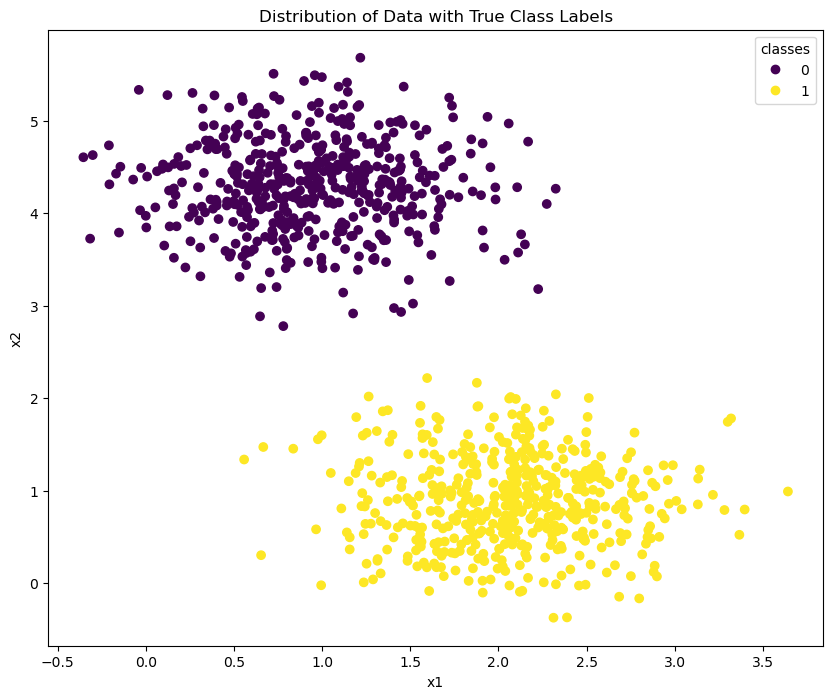

In [5]:
# visualise the data
fig, ax = plt.subplots(figsize=(10,8))
sc      = ax.scatter(X[:,0],X[:,1],c=y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with True Class Labels')
ax.legend(*sc.legend_elements(), title='classes')
plt.show()

It is evident that the two classes are concentrated into clumps, and are linearly separable. Let's see how our Perceptron performs:

In [6]:
# declare an instance of our Perceptron class
model1 = Perceptron(lr=0.1, verbose=True)

Creating instance with parameters: lr = 0.1, max_epochs = 100, and tol = 0.001


In [7]:
# fit the model on our training data
model1.fit(X_train,y_train)

Epoch: 0, Loss: 0.01375
Epoch: 1, Loss: 0.01375
Epoch: 2, Loss: 0.00625
Epoch: 3, Loss: 0.00625
Epoch: 4, Loss: 0.00625
Epoch: 5, Loss: 0.00375
Epoch: 6, Loss: 0.0025
Early stopping training procedure at Epoch: 7, Loss: 0.0


In [8]:
# view weights
model1.get_weights()

array([ 1.        ,  0.91207556, -1.02360788])

In [9]:
# generate predictions on the test set
y_pred = model1.predict(X_test)

In [10]:
# how accurate are the predictions?
acc = accuracy_score(y_test,y_pred)
pre = precision_score(y_test,y_pred,average='weighted')
rec = recall_score(y_test,y_pred,average='weighted')
f1  = f1_score(y_test,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 1.0000
Precision score: 1.0000
Recall score: 1.0000
F1 score: 1.0000


In [11]:
# check out what we get from the scikit-learn Perceptron?
from sklearn.linear_model import Perceptron as sklearn_Perceptron

model2 = sklearn_Perceptron(random_state=42)
model2.fit(X_train,y_train)
y_pred = model2.predict(X_test)

acc = accuracy_score(y_test,y_pred)
pre = precision_score(y_test,y_pred,average='weighted')
rec = recall_score(y_test,y_pred,average='weighted')
f1  = f1_score(y_test,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 1.0000
Precision score: 1.0000
Recall score: 1.0000
F1 score: 1.0000


## Classification Dataset Example #2

Let's create a second classification example involving two class labels. However, in this case the classes will not be linearly separable.

In [12]:
# make a dataset
X,y = make_circles(n_samples=1000, noise=0.03, random_state=0)

In [13]:
# do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

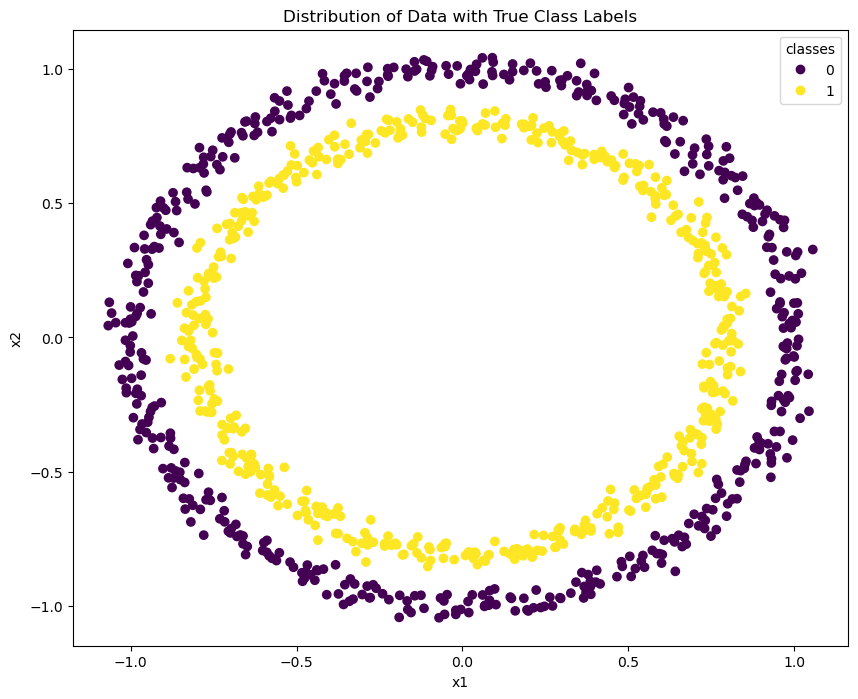

In [14]:
# visualise the data
fig, ax = plt.subplots(figsize=(10,8))
sc      = ax.scatter(X[:,0],X[:,1],c=y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with True Class Labels')
ax.legend(*sc.legend_elements(), title='classes')
plt.show()

Unlike the previous dataset, here the two classes are situated in concentric rings. As such, these classes are not linearly separable. Now how does our Perceptron do?

In [15]:
# fit the model on our training data
model1.fit(X_train,y_train)

Epoch: 0, Loss: 0.48875
Early stopping training procedure at Epoch: 1, Loss: 0.5025000000000001


In [16]:
# generate predictions on the test set
y_pred = model1.predict(X_test)

# how accurate are the predictions?
acc = accuracy_score(y_test,y_pred)
pre = precision_score(y_test,y_pred,average='weighted')
rec = recall_score(y_test,y_pred,average='weighted')
f1  = f1_score(y_test,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 0.4700
Precision score: 0.2209
Recall score: 0.4700
F1 score: 0.3005


/Users/mattard/anaconda/envs/blog2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


These results aren't that good, which is what we would expect for the Perceptron as the data are not linearly separable. How does the scikit-learn implementation fair?

In [17]:
# fit the model on our training data
model2.fit(X_train,y_train)

# generate predictions on the test set
y_pred = model2.predict(X_test)

# how accurate are the predictions?
acc = accuracy_score(y_test,y_pred)
pre = precision_score(y_test,y_pred,average='weighted')
rec = recall_score(y_test,y_pred,average='weighted')
f1  = f1_score(y_test,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 0.5450
Precision score: 0.5471
Recall score: 0.5450
F1 score: 0.5454


These results are also not impressive, indicating the classifier is unable to deal with the data in its current state. What we need is some feature engineering to better prepare our data.

### Feature Engineering of Predictors

We need to transform our data into a form where they are linearly separable. Once this is accomplished, our Perceptron should function well.

To accomplish this, let's convert the predictor features to polar coordinates:

In [18]:
# convert features to polar coordinates
radius = np.sqrt(X[:,0]**2+X[:,1]**2)
theta  = np.arctan2(X[:,1],X[:,0])
X_pol  = np.concatenate((radius.reshape(-1,1),theta.reshape(-1,1)),axis=1)

In [19]:
# do train test split
X_train, X_test, y_train, y_test = train_test_split(X_pol, y, test_size=0.2, random_state=42)

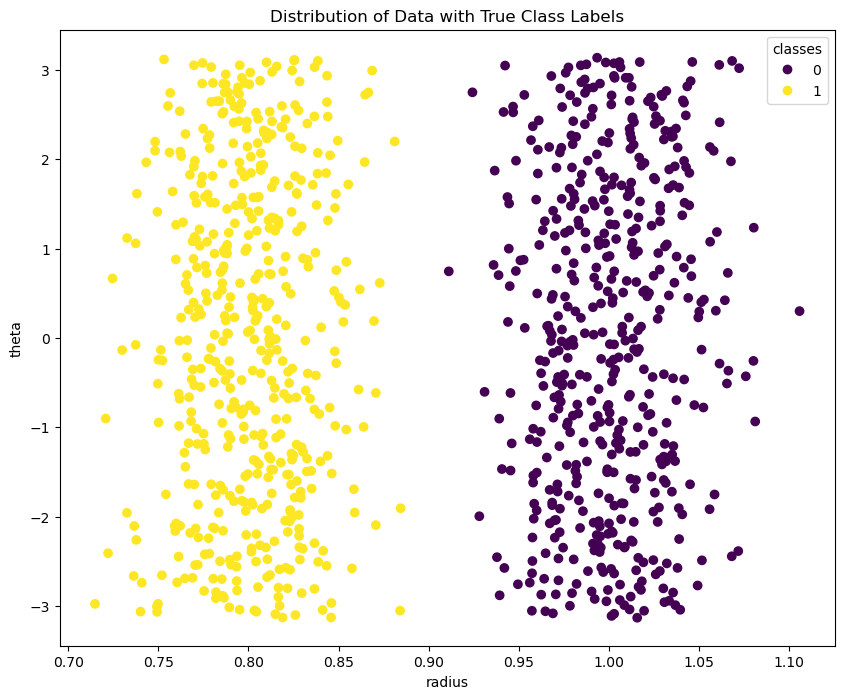

In [20]:
# visualise the data
fig, ax = plt.subplots(figsize=(10,8))
sc      = ax.scatter(X_pol[:,0],X_pol[:,1],c=y)
plt.xlabel('radius')
plt.ylabel('theta')
plt.title('Distribution of Data with True Class Labels')
ax.legend(*sc.legend_elements(), title='classes')
plt.show()

The transformation of the dataset has now yielded two features that are linearly separable. Now let's see how the Perceptron performs on these new features:

In [21]:
# fit the model on our training data
model1.fit(X_train,y_train)

Epoch: 0, Loss: 0.195
Early stopping training procedure at Epoch: 1, Loss: 0.0


In [22]:
# generate predictions on the test set
y_pred = model1.predict(X_test)

# how accurate are the predictions?
acc = accuracy_score(y_test,y_pred)
pre = precision_score(y_test,y_pred,average='weighted')
rec = recall_score(y_test,y_pred,average='weighted')
f1  = f1_score(y_test,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 1.0000
Precision score: 1.0000
Recall score: 1.0000
F1 score: 1.0000


In [23]:
# fit the model on our training data
model2.fit(X_train,y_train)

# generate predictions on the test set
y_pred = model2.predict(X_test)

# how accurate are the predictions?
acc = accuracy_score(y_test,y_pred)
pre = precision_score(y_test,y_pred,average='weighted')
rec = recall_score(y_test,y_pred,average='weighted')
f1  = f1_score(y_test,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 0.9950
Precision score: 0.9951
Recall score: 0.9950
F1 score: 0.9950


Our custom Perceptron implementation gets a perfect score on the test set! Furthermore, it does better than the scikit-learn model by a small margin on these data. 

This highlights an important fact about Perceptrons: they are highly dependant on hand-written features. They cannot learn these on their own! Therefore, an essential step to make use of Perceptrons is to first perform a feature engineering stage prior to training. This stage aims at making the input features linearly separable, so as to give the model the best chance at optimal performance. 